## Step 1. Download the Data
- This code is used to download and extract a dataset of cats and dogs images.
- The dataset is obtained from a publicly available source and is downloaded in .zip format.
- "!" Prefix is used to executes shell commands directly in a Jupyter Notebook or Python script with notebook-like capabilities (e.g., Google Colab or Kaggle Notebook).

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-12-25 08:36:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.135.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   174MB/s    in 0.4s    

2024-12-25 08:36:58 (174 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip /kaggle/working/cats_and_dogs_filtered.zip

Archive:  /kaggle/working/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validatio

## Step 2. Import Library
This code imports the essential libraries and modules needed to build, train, and evaluate a deep learning model for image classification tasks. 

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

## Step 3. Data Split and Augmentation
- This code demonstrates the preparation of image data for a deep learning model, including data augmentation for the training set, split and rescaling for the validation and test sets.
- After augmentation, the code display a batch of images from the training dataset, along with their corresponding class labels (e.g., "cat" or "dog") in a 4x4 grid using Matplotlib.

In [4]:
train_dir = '/kaggle/working/cats_and_dogs_filtered/train'
val_dir = '/kaggle/working/cats_and_dogs_filtered/validation'

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=40,         # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by 20% of height
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill pixels outside the input boundary
)

# Image preprocessing for validation and test sets, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),    
    batch_size=32,            
    class_mode='binary',
    shuffle=True
)

# Load validation data
validation_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',  # Mengambil subset sebagai validation
    shuffle=True
)

# Load test data
test_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # Mengambil subset sebagai test
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


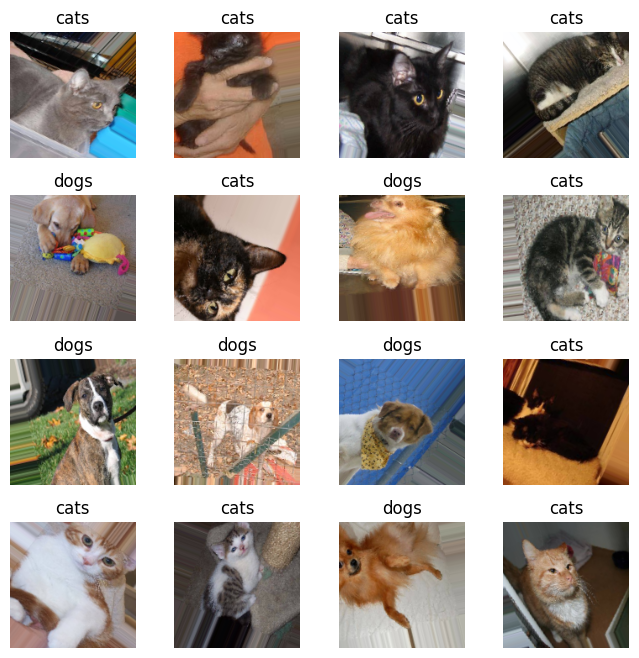

In [5]:
# Create a dictionary to map the class indices to class labels (e.g., 0 -> 'cat', 1 -> 'dog')
labels = {v: k for k, v in train_data.class_indices.items()}  # Mapping indeks ke nama kelas

# Get a batch of samples from train_data
sample_generate = train_data.__next__()
images = sample_generate[0]  # Batch gambar
titles = sample_generate[1]  # Batch label (binary: 0 atau 1)

# Plot image
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f'{labels[int(titles[i])]}')  # Convert binary label to the corresponding class name
    plt.axis("off")

## Step 4. Training
This code demonstrates how to fine-tune a MobileNetV2 model for a binary classification task. The model is pre-trained on ImageNet and customized by adding a few layers on top. Additionally, it uses callbacks for early stopping and learning rate reduction. Finally, it visualizes the training progress using accuracy and loss plots.

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze layer pre-trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer (binary classification)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

<ipython-input-6-a8b66a8e1f43>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=200,
    callbacks= [early_stopping, reduce_lr]
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.7917 - loss: 0.8672 - val_accuracy: 0.9580 - val_loss: 0.1191 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9226 - loss: 0.1912 - val_accuracy: 0.9500 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.9318 - loss: 0.1575 - val_accuracy: 0.9620 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9285 - loss: 0.1670 - val_accuracy: 0.9400 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9349 - loss: 0.1694 - val_accuracy: 0.9540 - val_loss: 0.1115 - learning_rate: 2.0000e-04
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.9368 - loss: 0.1565 - val_accuracy: 0.9600 - val_loss: 0.1091 - learning_rate: 2.0000e-04
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.9371 - loss:

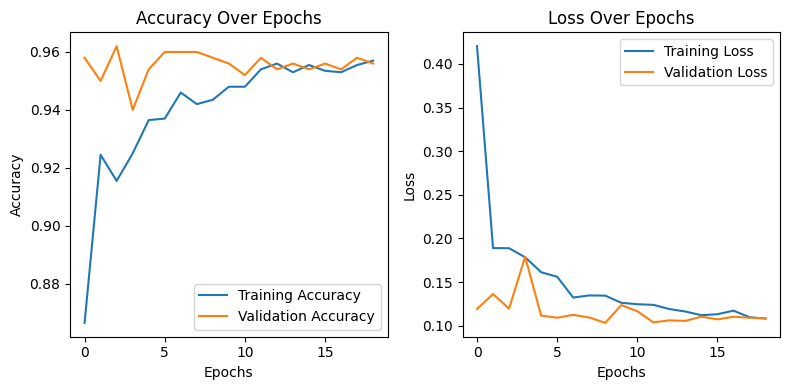

In [9]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # Create a 1x2 grid, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Step 5. Evaluation
- This code is used to evaluate model using the `evaluate` method on the `test_data`.
- Next, the model predicts the labels for the test data using the predict method.
- A confusion matrix is calculated to evaluate the model’s performance by comparing the predicted classes against the true labels.
- The classification report provides a detailed performance summary, including precision, recall, f1-score, and support for each class. 

In [10]:
# Evaluate test data
test_score = model.evaluate(test_data)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1483
Test Loss:  0.10947304219007492
Test Accuracy:  0.9580000042915344


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step


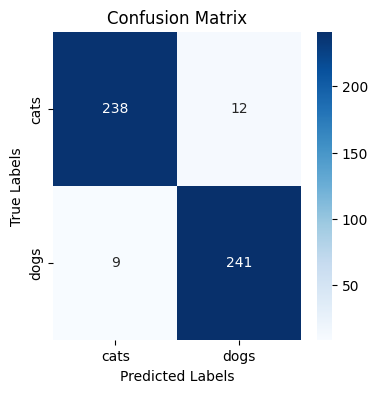

In [11]:
predictions = model.predict(test_data, batch_size=32)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to 0 or 1 (binary classification)

# Get the true labels from the test data
true_classes = test_data.classes  # Ground truth labels
class_labels = list(test_data.class_indices.keys())  # The class labels (e.g., 'cat' and 'dog')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [12]:
# Compute classification report
report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        cats       0.96      0.95      0.96       250
        dogs       0.95      0.96      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



## Step 6. Save The Model

In [13]:
!pip install tensorflowjs

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.1.0 which is incompatible.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.
pandas-gbq 0.23.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.


In [14]:
import tensorflowjs as tfjs

# Save the model in HDF5 format
model.save('model_3c.h5')

# Save model in .keras format
model.save('model_3c.keras')

# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'model_3c_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


In [15]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to .tflite file
with open('model_3c.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpu7ki4l1e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137472552990880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027857792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027856208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027857264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027858144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027864304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027863952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027867648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027865008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027865888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13747202823163

In [17]:
model.export("saved_model_3c")

Saved artifact at 'saved_model_3c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137472552990880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027857792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027856208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027857264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027858144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027864304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027863952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027867648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027865008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472027865888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137472028231632: